# Lab 02: Personalizar Stable Diffusion 🧨

Referencias:

- \[1\] [Textual Inversion - Hugging Face / 🧨 Diffusers Documentation](https://huggingface.co/docs/diffusers/training/text_inversion)
- \[2\] [Textual-inversion fine-tuning for Stable Diffusion using d🧨ffusers - Colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb)
- \[3\] [Cool Japan Diffusion 2.1.0 - 🤗 Hugging Face](https://huggingface.co/aipicasso/cool-japan-diffusion-2-1-0)
- \[4\] [Stable Diffusion Fine Tuned on Pokémon - 🤗 Hugging Face](https://huggingface.co/lambdalabs/sd-pokemon-diffusers)
- \[5\] [Stable Diffusion using Hugging Face - Variations of Stable Diffusion - Towards Data Science](https://towardsdatascience.com/stable-diffusion-using-hugging-face-variations-of-stable-diffusion-56fd2ab7a265) 
- \[6\] [Stable Conceptualizer Inference - Google Colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb)

## Parte 01: Modelos de la comunidad

Una peculiaridad de Stable Diffusion es que se puede personalizar re entrenando el modelo. En el cuaderno anterior habiamos usado _"stabilityai/stable-diffusion-2-1"_ como modelo, pero también hay versiones anteriores a esta como:

- _"CompVis/stable-diffusion-v1-4"_
- _"runwayml/stable-diffusion-v1-5"_
- _"stabilityai/stable-diffusion-2"_

La diferencia con el modelo que habiamos usado simplemente esta en la calidad y detalles menores.

### 0.1. Instalar librerías

In [ ]:
!pip install -q -U transformers diffusers==0.14.0 accelerate ftfy fpuna-stable-diffusion

### 1.1 Utilizar modelos de la comunidad

Hugging Face es una plataforma que contiene modelos y base de datos que la comunidad aporta. De hecho, es el encargado de mantener la librería 🧨 Diffusers que nos permite generar imágenes. Cada modelo mencionado arriba tiene su entrada en la plataforma, por ejemplo, "stabilityai/stable-diffusion-2-1" se encuentra en https://huggingface.co/stabilityai/stable-diffusion-2-1 .

Si bien podemos generar buenas imágenes, a veces necesitamos crear nuestros propios modelos con nuestros propios datos para adaptar a nuestras necesidades. Un ejemplo de esto es [_lambdalabs/sd-pokemon-diffusers_](https://huggingface.co/lambdalabs/sd-pokemon-diffusers) que fue entrenado sobre una base de datos de pokemon

Veamos como utilizar este modelo:

In [2]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("lambdalabs/sd-pokemon-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

La inicialización no difiere tanto de como habiamos aprendido, solamente debemos cambiar el nombre del modelo. Tampoco cambia la forma de generar imágenes.

  0%|          | 0/50 [00:00<?, ?it/s]

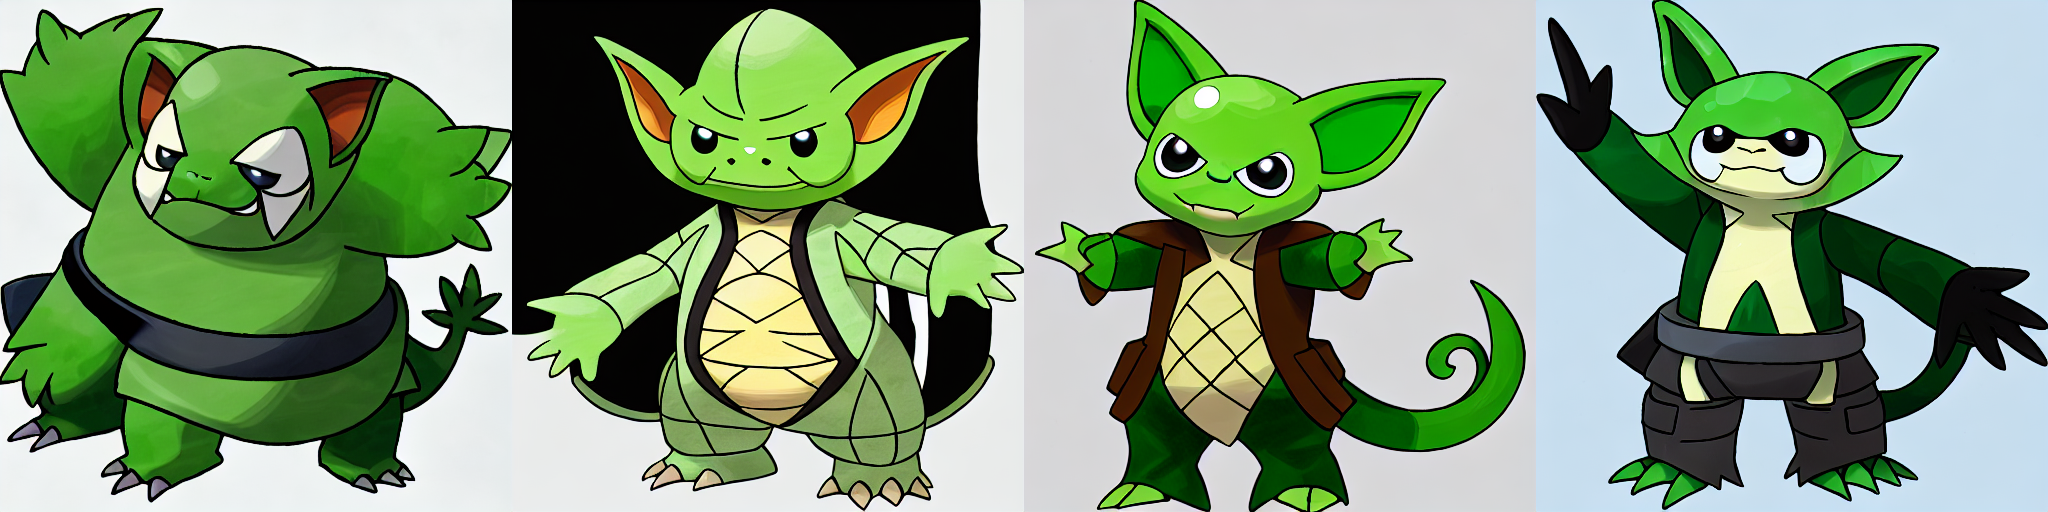

In [3]:
from fpuna_stable_diffusion.utils import image_grid

prompt = "Yoda"
scale = 10
n_samples = 4

with torch.autocast("cuda"):
    images = pipe(n_samples*[prompt], guidance_scale=scale).images
    
grid = image_grid(images, rows=1, cols = n_samples)

grid

Aquí `torch.autocast` cumple la función de computar en precisión mixta, no es necesario entender su funcionamiento pero su uso acelera la generación de imágenes. Es posible también que el filtro NSFW se confunda con las imágenes de Pokemon, por lo que podemos desactivarlo de la siguiente manera:

  0%|          | 0/50 [00:00<?, ?it/s]

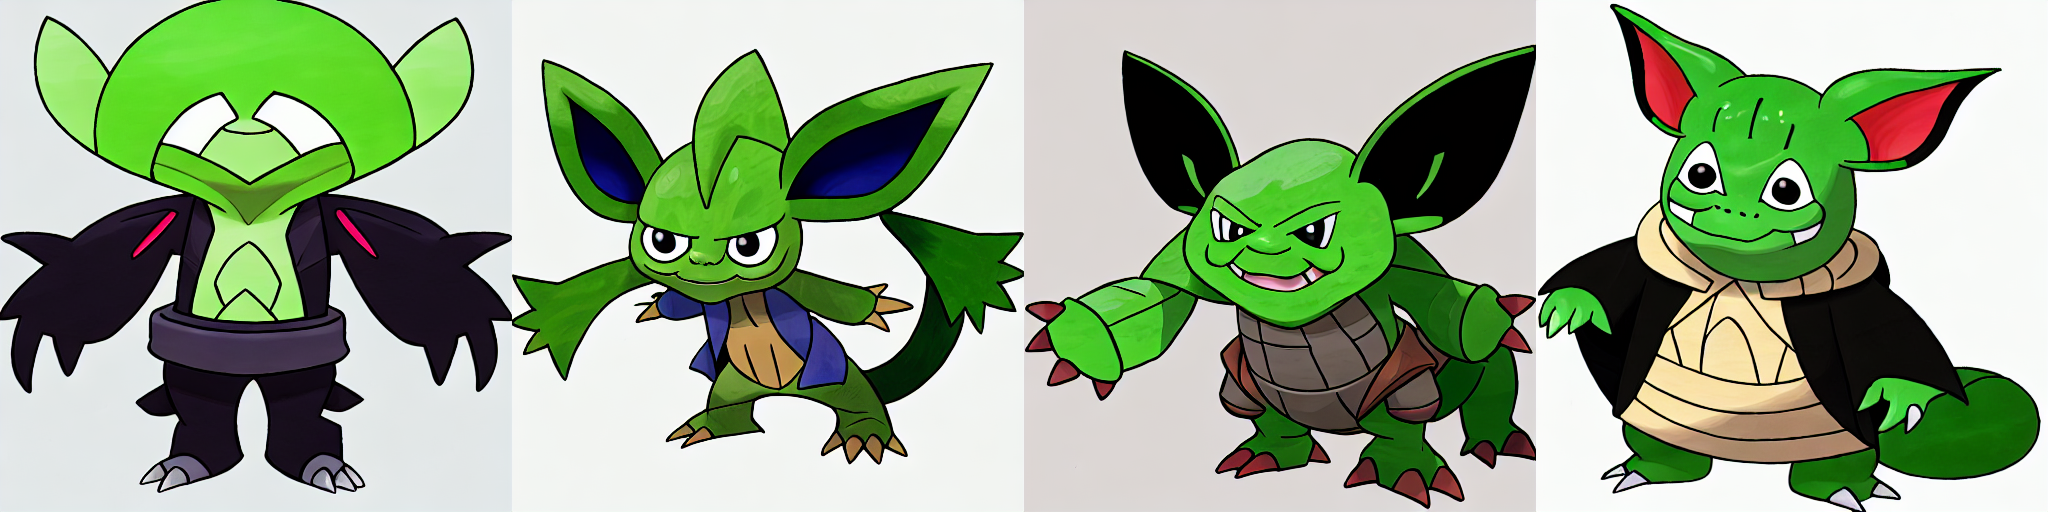

In [4]:
def null_safety(images, **kwargs):
      return images, False

pipe.safety_checker = null_safety 

with torch.autocast("cuda"):
    images = pipe(n_samples*[prompt], guidance_scale=scale).images
    
grid = image_grid(images, rows=1, cols = n_samples)

grid

### 1.2. Cool Japan Diffusion

![CoolJapanDiffusion](https://huggingface.co/aipicasso/cool-japan-diffusion-2-1-0/resolve/main/eyecatch.jpg)

Probemos otro modelo de 🤗 Hugging Face llamado [Cool Japan Diffusion](https://huggingface.co/aipicasso/cool-japan-diffusion-2-1-0). Este modelo nos genera las imágenes en un estilo similar al de los animes. Modelos parecidos a estos son los que usan los filtros en aplicaciones como TikTok.

In [10]:
pipe = StableDiffusionPipeline.from_pretrained("aipicasso/cool-japan-diffusion-2-1-0-beta", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


Una de las ventajas de Stable Diffusion es que podemos decirle que no queremos ver en la imagen generada, a esta capacidad lo llamamos **Negative Prompting**. Esto es muy útil cuando queremos remover conceptos de la imagen que no queremos ver. Generemos una imagen con este modelo entonces de la siguiente manera:

  0%|          | 0/50 [00:00<?, ?it/s]

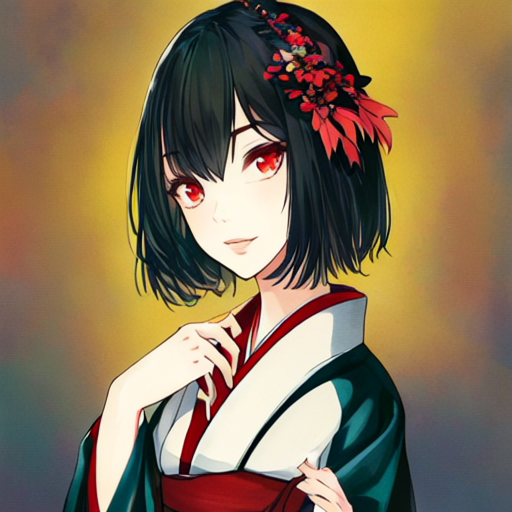

In [13]:
with torch.autocast("cuda"):
    image = pipe("anime, a portrait of a girl with black short hair and red eyes, kimono, full color illustration, official art, 4k, detailed",
                 negative_prompt="low quality, bad face, bad anatomy, bad hand, lowres, jpeg artifacts, 2d, 3d, cg, text").images[0]
    
image

### 1.3. Stable Diffusion con Conceptos Nuevos

A parte de adaptar los modelos, también es posible agregar nuevos conceptos. De forma práctica, sería como agregar nuevas palabras. 🤗 Hugging Face tiene una base de datos de conceptos enseñados por la comunidad que se pueden utilizar con Stable Diffusion 🧨 llamado [SD Concepts Library](https://huggingface.co/sd-concepts-library). Algo increible de esto, es que no solo se agregan conceptos, sino también estilos.

![SD-CONCEPT](https://i.imgur.com/Wb1cVzK.png)

Probemos entonces como podemos usar los nuevos conceptos. En la sección de modelos tenemos varios conceptos, elijamos uno que nos interese. Por ejemplo: [sd-concepts-library/bonzi-monkey](https://huggingface.co/sd-concepts-library/bonzi-monkey). Para esto, antes de crear el modelo de Stable Diffusion, tenemos que modificar un poco el **Text Encoder**, que es el encargado de mandar el texto al modelo de difusión.

In [16]:
from transformers import CLIPTokenizer, CLIPTextModel

tokenizer = CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="tokenizer",
)

text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder="text_encoder", torch_dtype=torch.float16
)

In [17]:
def load_learned_embed_in_clip(learned_embeds_path, text_encoder, tokenizer, token=None):
    loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")
  
    # separate token and the embeds
    trained_token = list(loaded_learned_embeds.keys())[0]
    embeds = loaded_learned_embeds[trained_token]

    # cast to dtype of text_encoder
    dtype = text_encoder.get_input_embeddings().weight.dtype
    embeds.to(dtype)

    # add the token in tokenizer
    token = token if token is not None else trained_token
    num_added_tokens = tokenizer.add_tokens(token)
    if num_added_tokens == 0:
        raise ValueError(f"The tokenizer already contains the token {token}. Please pass a different `token` that is not already in the tokenizer.")
  
    # resize the token embeddings
    text_encoder.resize_token_embeddings(len(tokenizer))
  
    # get the id for the token and assign the embeds
    token_id = tokenizer.convert_tokens_to_ids(token)
    text_encoder.get_input_embeddings().weight.data[token_id] = embeds

Descarguemos el concepto que vamos a utilizar:

In [19]:
from huggingface_hub import hf_hub_download
import os

# Crea la carpeta donde se va a descargar
downloaded_embedding_folder = "./downloaded_embedding"
if not os.path.exists(downloaded_embedding_folder):
    os.mkdir(downloaded_embedding_folder)

# Descarga el concepto
embeds_path = hf_hub_download(repo_id="sd-concepts-library/bonzi-monkey", filename="learned_embeds.bin")
token_path = hf_hub_download(repo_id="sd-concepts-library/bonzi-monkey", filename="token_identifier.txt")
!cp $embeds_path $downloaded_embedding_folder
!cp $token_path $downloaded_embedding_folder
with open(f'{downloaded_embedding_folder}/token_identifier.txt', 'r') as file:
    placeholder_token_string = file.read()

Veamos cual es la palabra que le corresponde a nuestro concepto:

In [22]:
placeholder_token_string

'<bonzi>'

Ahora carguemos nuestro concepto al codificador de texto de modo que este disponible para su uso:

In [20]:
# Cargamos el concepto al Text Encoder
load_learned_embed_in_clip(f"{downloaded_embedding_folder}/learned_embeds.bin",
                          text_encoder=text_encoder,
                          tokenizer=tokenizer)

Creamos el pipe de Stable Diffusion con el Text Encoder modificado

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
).to("cuda")

Generamos imágenes utilizando nuestro nuevo concepto. En nuestro caso tenemos \<bonzi\>:

  0%|          | 0/50 [00:00<?, ?it/s]

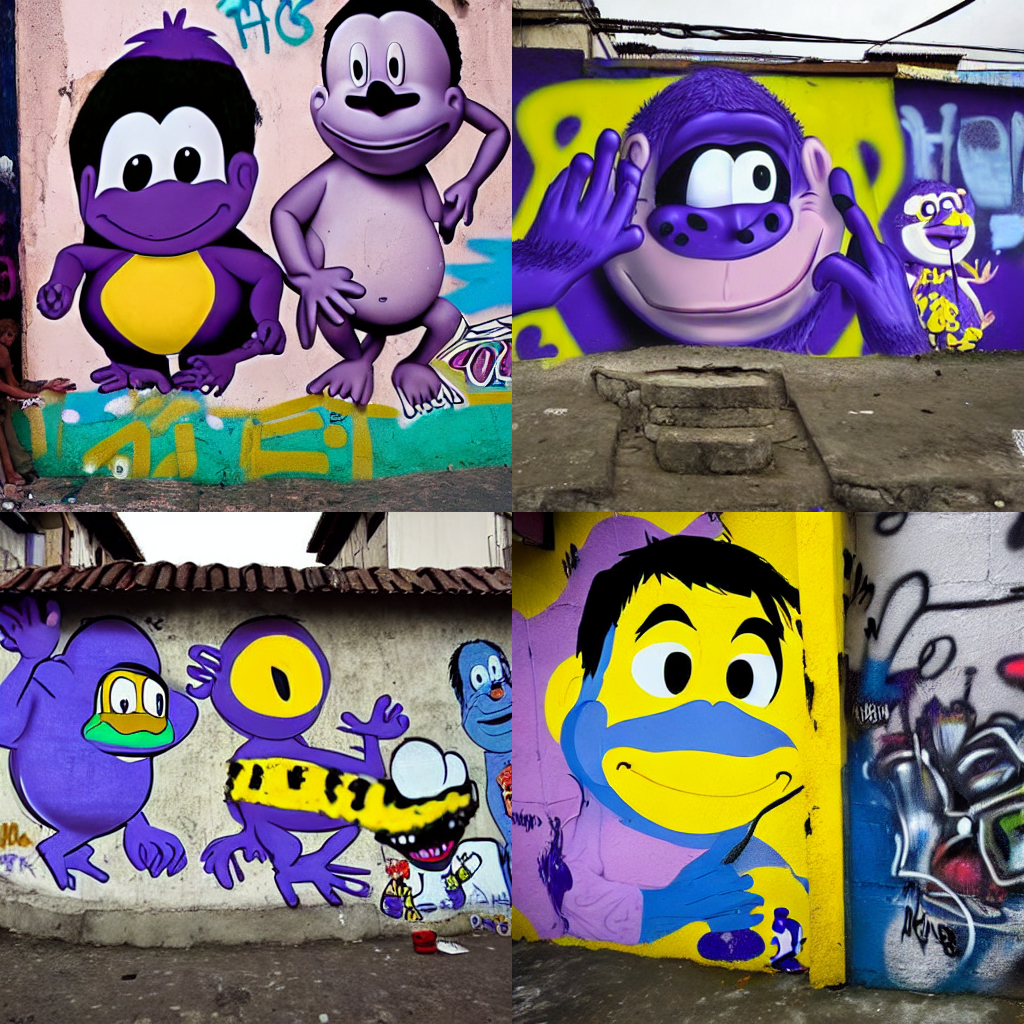

In [23]:
prompt = ["a grafitti in a favela wall with a <bonzi> on it"] * 4

with torch.autocast("cuda"):
    images =  pipe(prompt).images
    
image_grid(images, rows=2, cols=2)    